## Importing Libraries

In [1]:
from importlib import reload
import pandas as pd
import model_selection as ms
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
reload(ms)

<module 'model_selection' from 'e:\\Ames-Housing-Price-Predictor\\notebooks\\model_selection.py'>

## Load dataset

In [2]:
df = pd.read_parquet('../data/processed/06_feature_selection.parquet')

In [3]:
x = df.drop(columns=['saleprice'])
y = df['saleprice']
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
)

## Model Training

Based on the results from `07_model_selection.ipynb`, the best-performing model was the `CatBoostRegressor`. Therefore, in this notebook, I will focus on tuning the `CatBoost` model to further improve its performance.

In [5]:
models = {
    'CatBoost': CatBoostRegressor(task_type='GPU', devices='0', verbose=0),
}

In [6]:
from scipy.stats import loguniform, randint

param_dist = {
    'CatBoost': {
        'iterations':   randint(100, 300),
        'learning_rate': loguniform(1e-3, 0.2),
        'depth':        randint(4, 8),
        'l2_leaf_reg':  [1, 3, 5, 10]
    }
}


In [7]:
reload(ms)
models_pro = ms.regression_hyperparameter_tuning(x_train, y_train, models, param_dist, cv=2, n_iter = 50)

✅ Tuning hyperparameter for CatBoost...
Best hyperparameters for CatBoost: {'depth': 7, 'iterations': 182, 'l2_leaf_reg': 1, 'learning_rate': np.float64(0.08809893986914877)}



In [8]:
reload(ms)
regression_metrics, predictions_dict, importances_dict = ms.model_predict(models_pro, x_train, x_test, y_train, y_test)


✅ Testing CatBoost...
MAE: 13445.54553441261 | MSE: 431930506.2122486 | RMSE: 20782.937862878014 | R²: 0.9461268569973682 | RMSLE: 0.10101886338592207 | MAPE: 0.07379123993348782
--------------------------------------------------


## Model Evaluation

In [9]:
regression_metrics

,Model,MAE,MSE,RMSE,R²,RMSLE,MAPE
0,CatBoost,13445.545534,4.319305e+08,20782.937863,0.946127,0.101019,0.073791


### Residuals Plot

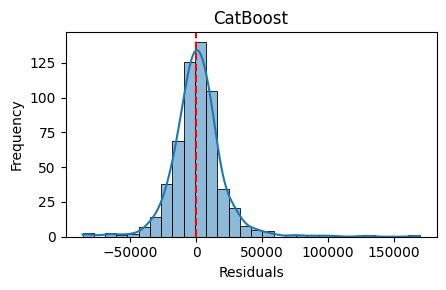

In [10]:
reload(ms)
ms.plot_residuals(y_test, predictions_dict, n_cols=5)

### Scatter Plot

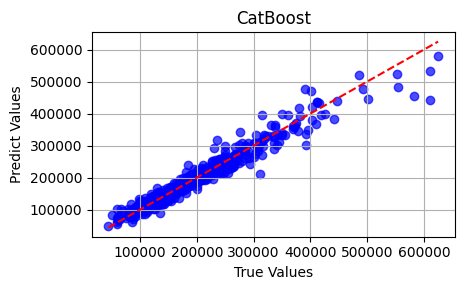

In [11]:
reload(ms)
ms.scatter_plot(y_test, predictions_dict, n_cols=5)

### Feature Importance

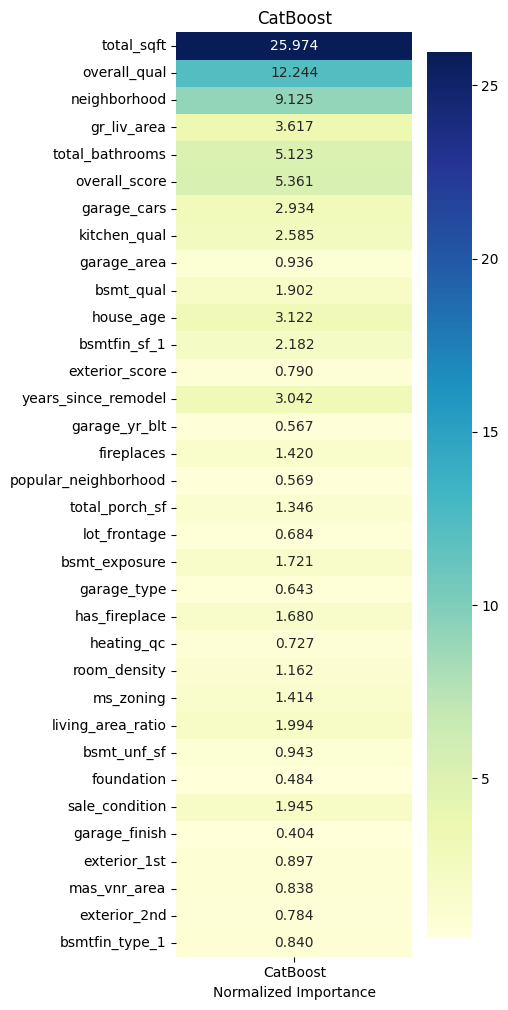

In [16]:
reload(ms)
ms.plot_feature_importances(x.columns,importances_dict)

### Learning Curve

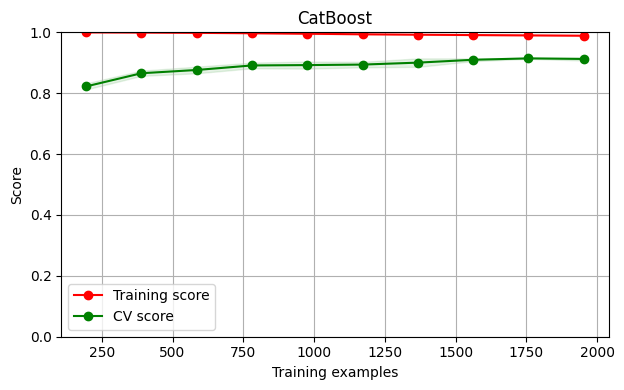

In [18]:
reload(ms)
learning_curve_summary = ms.learning_curves_regression(models_pro, x, y, cv=3, scoring='r2', cols=2)

### Learning Curve Summary

In [20]:
learning_curve_summary

,Model,Train score,CV score,Gap,Best n_samples
0,CatBoost,0.988864,0.912535,0.076328,1757


### Best Model

In [22]:
models_pro['CatBoost'].save_model('../models/catboost_model_pro.cbm')